In [2]:
# import support vector machine related libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [3]:
#read the flights file
df = pd.read_csv("flights.csv")
df.drop('Unnamed: 0',axis = 1, inplace = True)
df.drop('Age',axis = 1, inplace = True)
df.head()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


In [4]:
# set satisfied as 1 others as 0
df['satisfaction'] = df['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)

In [5]:
df = df.dropna()

In [6]:
df['satisfaction'].value_counts()

satisfaction
0    14528
1    11365
Name: count, dtype: int64

In [7]:
df.shape

(25893, 17)

In [8]:
# select x,y
feature = 'satisfaction'

X = df.drop(feature, axis=1)
y = df[feature]

In [9]:
# training and test set 
# build pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02,random_state=42)
pipe = Pipeline(
    steps = [
        ('scaler',MinMaxScaler()),
        ('pca', PCA(n_components=2)),
        ('svc', SVC(C = 1, kernel = 'linear',probability = True))
    ]
)


In [10]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=2)),
                ('svc', SVC(C=1, kernel='linear', probability=True))])

In [11]:
y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.7567567567567568


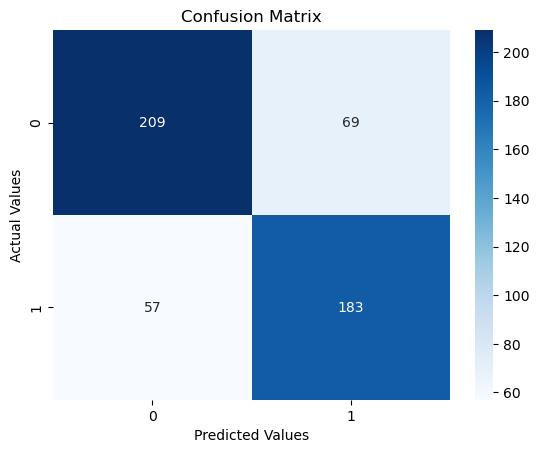

In [12]:
# Confusion matrix
confusion = confusion_matrix(y_test,y_pred)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix")
plt.show()

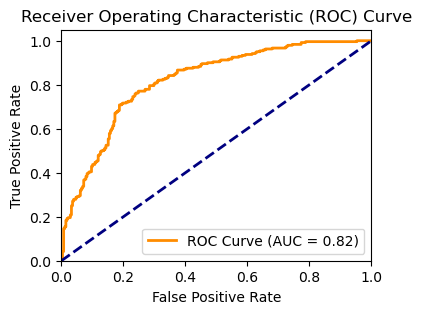

In [13]:
# Get predicted probabilities for the positive class
y_probs = pipe.predict_proba(X_test)[:,1]

# Calculate the ROC curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

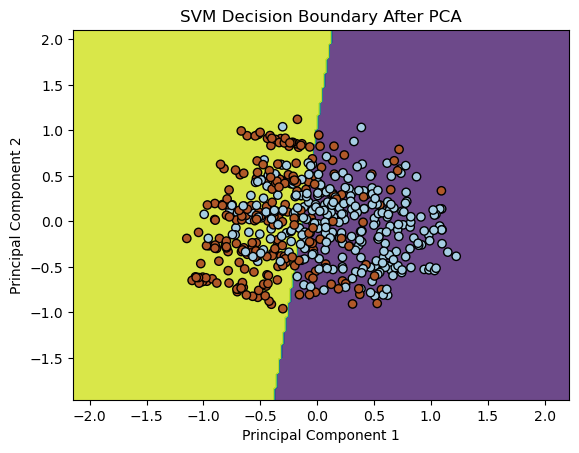

In [14]:
# Scale and decompostion of the train and test data
X_train_pca = pipe.named_steps['pca'].transform(pipe.named_steps['scaler'].transform(X_train))
X_test_pca = pipe.named_steps['pca'].transform(pipe.named_steps['scaler'].transform(X_test))

# Train an SVM model on the reduced-dimension data
svm_linear = pipe.named_steps['svc']
svm_linear.fit(X_train_pca, y_train)

# Create a meshgrid for decision boundary visualization
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = svm_linear.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predictions and plot the decision boundary
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary After PCA')
plt.show()

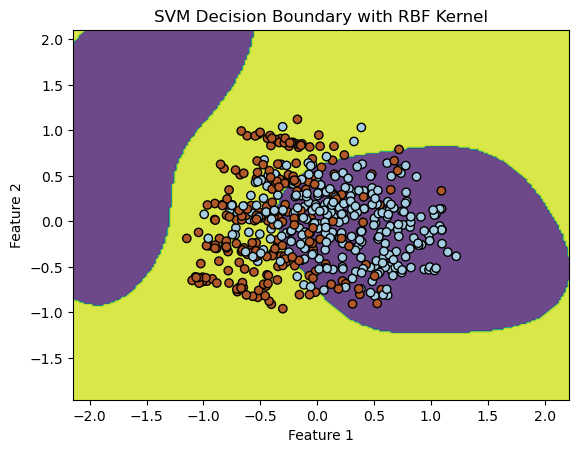

In [15]:
# non-linear model
svm_non_linear = SVC(kernel='rbf', C=1, gamma=0.7)
svm_non_linear.fit(X_train_pca, y_train)

# Create a meshgrid for decision boundary visualization
Z = svm_non_linear.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predictions and plot the decision boundary
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary with RBF Kernel')
plt.show()